In [29]:
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import Polygon


# Step 1: Create synthetic temperature data using xarray

In [30]:
# Generate a grid of lat/lon coordinates
lat = np.linspace(-10, 10, 100)
lon = np.linspace(-10, 10, 100)

# Generate synthetic temperature data (in °C)
temperature_data = 20 + 10 * np.random.rand(len(lat), len(lon))

# Create an xarray Dataset
ds = xr.Dataset(
    {
        "temperature": (["lat", "lon"], temperature_data),
    },
    coords={
        "lat": lat,
        "lon": lon,
    }
)

# View the Dataset
print(ds)

<xarray.Dataset>
Dimensions:      (lat: 100, lon: 100)
Coordinates:
  * lat          (lat) float64 -10.0 -9.798 -9.596 -9.394 ... 9.596 9.798 10.0
  * lon          (lon) float64 -10.0 -9.798 -9.596 -9.394 ... 9.596 9.798 10.0
Data variables:
    temperature  (lat, lon) float64 27.46 24.19 23.31 ... 22.85 24.33 20.63


In [31]:
temperature_data.min(), temperature_data.max()

(20.000202306522283, 29.99954412192692)

# Step 2: Define temperature bins and classify data

In [32]:
# setting bins and labels
nbins = 9
bins = np.linspace(temperature_data.min(), temperature_data.max(), nbins+1)[:-1] # use nbins + 1 to ensure at least one >bins[-1]
labels = [f'{bins[i]}-{bins[i+1]}°C' for i in range(len(bins)-1)] + [f'>{bins[-1]}°C']

# Classify temperature data into bins
ds['temp_bins'] = xr.apply_ufunc(
    np.digitize, ds['temperature'], bins, dask='allowed', output_dtypes=[int]
)

ds['temp_bins'] = ds['temp_bins'] - 1  # Ensure the beginning with 0
print(ds['temp_bins'])

<xarray.DataArray 'temp_bins' (lat: 100, lon: 100)>
array([[3, 2, 1, ..., 0, 1, 4],
       [3, 3, 1, ..., 2, 1, 0],
       [4, 1, 3, ..., 4, 4, 1],
       ...,
       [3, 1, 2, ..., 3, 2, 4],
       [4, 0, 2, ..., 1, 0, 4],
       [1, 0, 3, ..., 1, 2, 0]])
Coordinates:
  * lat      (lat) float64 -10.0 -9.798 -9.596 -9.394 ... 9.394 9.596 9.798 10.0
  * lon      (lon) float64 -10.0 -9.798 -9.596 -9.394 ... 9.394 9.596 9.798 10.0


In [34]:
# Function to create a polygon for each grid cell
def create_polygon(lat_values, lon_values):
    polygons = []
    for i in range(len(lat_values) - 1):  # Subtract 1 to work with cells, not points
        for j in range(len(lon_values) - 1):
            lat_min, lat_max = lat_values[i], lat_values[i+1]
            lon_min, lon_max = lon_values[j], lon_values[j+1]
            polygon = Polygon([
                (lon_min, lat_min),
                (lon_min, lat_max),
                (lon_max, lat_max),
                (lon_max, lat_min)
            ])
            polygons.append(polygon)
    return polygons

# Generate the polygons (99x99 = 9801 polygons)
polygons = create_polygon(ds['lat'].values, ds['lon'].values)

# Adjust temperature bins to match cell grid (not point grid)
temperature_bins = ds['temp_bins'].values[:-1, :-1].flatten()

9801 9801
                                            geometry   values  temperature_bin
0  POLYGON ((-10.00000 -10.00000, -10.00000 -9.79...  26-28°C                3
1  POLYGON ((-9.79798 -10.00000, -9.79798 -9.7979...  24-26°C                2
2  POLYGON ((-9.59596 -10.00000, -9.59596 -9.7979...  22-24°C                1
3  POLYGON ((-9.39394 -10.00000, -9.39394 -9.7979...  22-24°C                1
4  POLYGON ((-9.19192 -10.00000, -9.19192 -9.7979...  26-28°C                3


# Step 4: Create a GeoDataFrame with polygons and temperature slices

<Axes: >

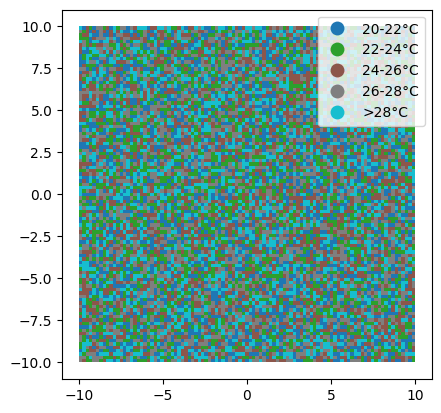

In [46]:
# Create a new column 'temperature_slice' based on the labels
temperature_slices = np.array([labels[bin_idx] if bin_idx >= 0 else None for bin_idx in temperature_bins])

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame({
    'geometry': polygons,
    'temperature_bin': temperature_bins,
    'temperature_slice': temperature_slices  # Add temperature range labels
})

gdf = gdf[gdf['temperature_bin'] >= 0]

gdf.plot(column='temperature_slice', legend=True)